In [108]:
import numpy as np, pandas as pd
from collections import Counter
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt, seaborn as sns
sns.set()
#%pylab inline
np.random.seed(19)

In [2]:
train = pd.read_csv("./Files/train.csv", dtype = {'id': 'str'})
train['label'] = (train['target'] > 0).astype(int)

In [4]:
train.shape, train['id'].nunique()

((903653, 35), 714167)

In [6]:
np.sum(train['target'] > 0), train[train['target'] > 0]['id'].nunique()

(11515, 9996)

* Количество сессий: 903653. Закончились покупкой: 11515.
* Количество пользователей: 714167. Что-то покупали: 9996.

Чуть больше одного процента пользователей совершали покупку!

Посмотрим на распределение целевой переменной:

In [11]:
sums = train[train['target'] > 0]['target'].values

(12, 24)

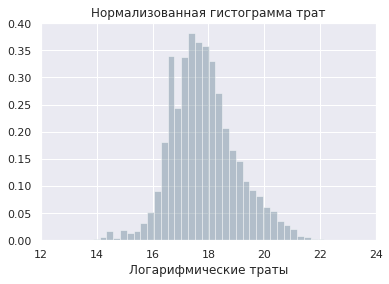

In [50]:
plt.title('Нормализованная гистограмма трат')
plt.xlabel('Логарифмические траты')
sns.distplot(np.log1p(sums), kde = False, color = sns.xkcd_rgb["blue grey"], bins = 60, norm_hist=True)
plt.xlim(12, 24)

In [51]:
train['date'] = train['date'].apply(lambda x: datetime.date(int(x[:4]), int(x[5:7]), int(x[8:])))

In [56]:
print(np.min(train['date']), np.max(train['date']))

2016-08-01 2017-08-01


В трейне содержатся данные с 2016-08-01 по 2017-08-01, т.е. ровно для годового промежутка.

Посмотрим на временной ряд для средних трат:

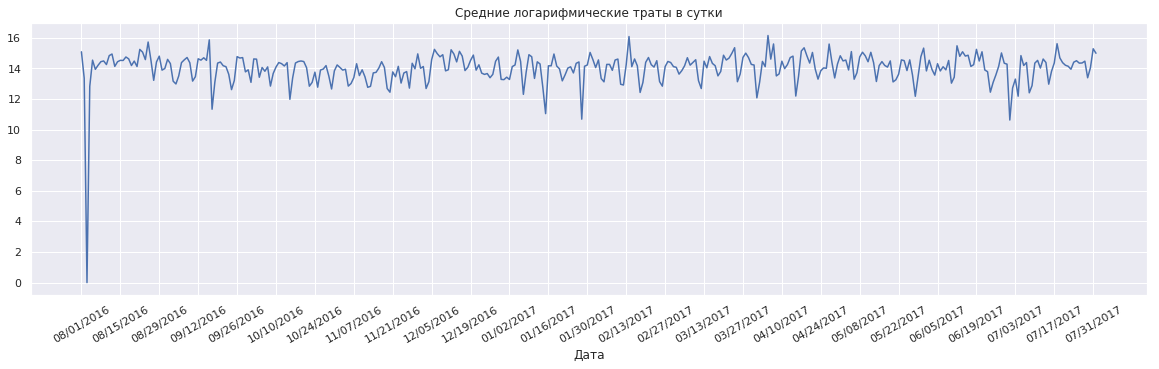

In [63]:
latest_date = np.max(train['date'])
oldest_date = np.min(train['date'])
calendar = [oldest_date + datetime.timedelta(days = i) for i in range((latest_date - oldest_date).days + 1)]

average_sums = train.groupby('date', sort = False)['target'].mean().apply(lambda x: np.log(1 + x))
plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(calendar, average_sums.loc[calendar, ])
plt.xticks(calendar[::14], rotation = 30)
plt.title('Средние логарифмические траты в сутки')
plt.xlabel('Дата')
#plt.ylim((10., 17.))
#plt.legend(regions)
#plt.gcf().autofmt_xdate()
plt.show()

In [81]:
x = train.groupby('date', sort = False)['target'].mean().sort_values()
print(x.values[0], x.index[0])
anomaly_day = x.index[0]
train[train['date'] == anomaly_day].shape

0.0 2016-08-03


(2890, 35)

2016-08-03 - какой-то аномальный день. Не было никаких трат - видимо, на сайте нельзя было ничего купить.

Тем не менее, в этот день было совершено 2890 заходов на сайт, которые, возможно, стоит не учитывать.

Теперь посмотрим на наш график получше, не обращая внимание на этот аномальный день:

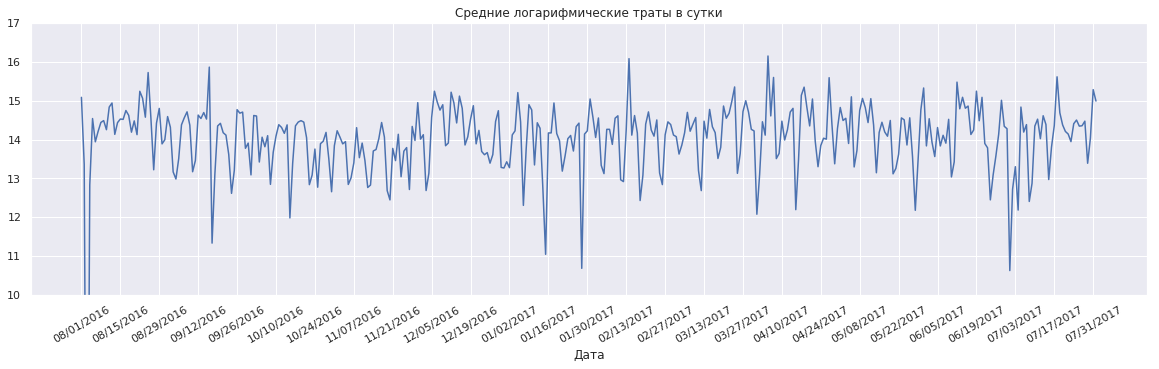

In [82]:
latest_date = np.max(train['date'])
oldest_date = np.min(train['date'])
calendar = [oldest_date + datetime.timedelta(days = i) for i in range((latest_date - oldest_date).days + 1)]

average_sums = train.groupby('date', sort = False)['target'].mean().apply(lambda x: np.log(1 + x))
plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(calendar, average_sums.loc[calendar, ])
plt.xticks(calendar[::14], rotation = 30)
plt.title('Средние логарифмические траты в сутки')
plt.xlabel('Дата')
plt.ylim((10., 17.))
#plt.legend(regions)
#plt.gcf().autofmt_xdate()
plt.show()

Исследуем количество посещений GStore'а:

In [93]:
n_visits = train.groupby('id', sort = False).size().values
print(Counter(n_visits).most_common()[:10])

[(1, 620675), (2, 58711), (3, 17159), (4, 7400), (5, 3633), (6, 2065), (7, 1231), (8, 838), (9, 538), (10, 384)]


Для 620675 пользователей в данных есть только одна сессия! Возможно их стоит анализировать отдельно?

Теперь посмотрим на количество посещений GStore'a в сутки:

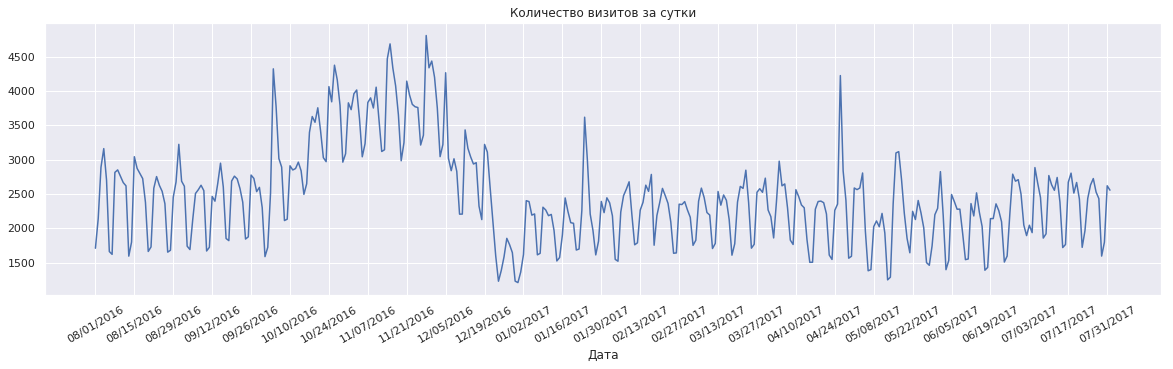

In [97]:
visits_by_day = Counter(train['date'])

plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(calendar, [visits_by_day[date] for date in calendar])
plt.xticks(calendar[::14], rotation = 30)
plt.title('Количество визитов за сутки')
plt.xlabel('Дата')
#plt.gcf().autofmt_xdate()
plt.show()

Данный временной ряд показывает удивительную сезонность: люди, почему-то, реже посещают GStore на выходных. Видимо, на работе больше свободного времени!

Ну и нельзя не отметить, что большой горб в ноябре/декабре что-то должен да значить: повторяется ли он в следующем году, можно увидеть в тесте.

Теперь поговорим о старом добром категориальном:

Ниже можно наблюдать некоторые из категориальных признаков в данных и их распределение.

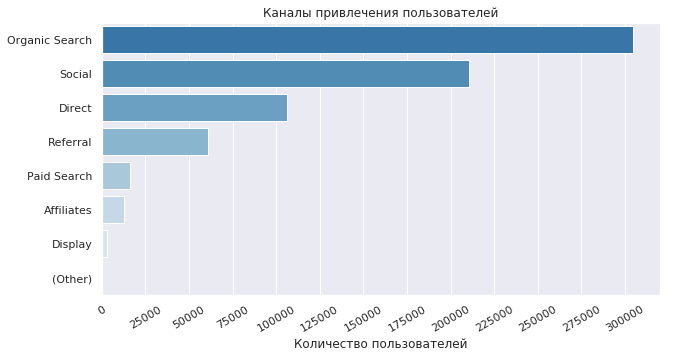

In [99]:
plt.figure(figsize=(10,5))

channel_values = train.groupby('id', sort = False).apply(lambda x: x['channel'].values[0]).values
cnt = Counter(channel_values)
palette = sns.color_palette('Blues', n_colors = len(cnt) + 2)

sns.countplot(y = channel_values, order = [el[0] for el in cnt.most_common()],
             palette = palette[::-1][2:])
plt.xlabel('Количество пользователей')
plt.title('Каналы привлечения пользователей')
plt.xticks(np.arange(0, 320000, 25000), rotation = 30)
plt.show()

In [100]:
browsers_nunique = train.groupby('id', sort = False)['device_browser'].nunique().values
print(Counter(browsers_nunique).most_common())

[(1, 713996), (2, 170), (4, 1)]


Большинство юзеров пользуется только одним браузером.

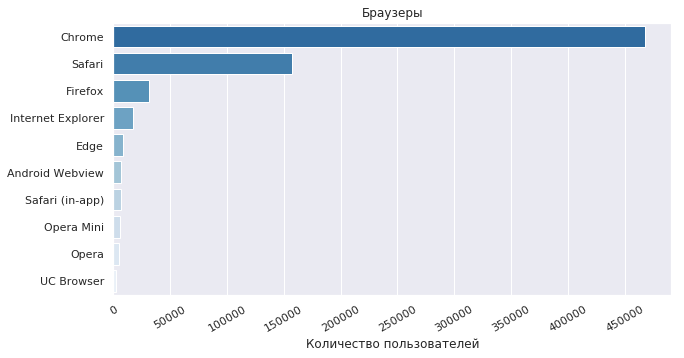

In [101]:
plt.figure(figsize=(10,5))

cnt = Counter(train.groupby('id', sort = False).apply(lambda x: Counter(x['device_browser']).most_common()[0][0]))
browser_values = sum([[el[0]] * el[1] for el in cnt.most_common()[:10]], [])
cnt = Counter(browser_values)
palette = sns.color_palette('Blues', n_colors = len(cnt) + 2)

sns.countplot(y = browser_values, order = [el[0] for el in cnt.most_common()],
             palette = palette[::-1][2:])
plt.xlabel('Количество пользователей')
plt.title('Браузеры')
plt.xticks(np.arange(0, 500000, 50000), rotation = 30)
plt.show()

In [102]:
devices_nunique = train.groupby('id', sort = False)['device_deviceCategory'].nunique().values
Counter(devices_nunique).most_common()

[(1, 714167)]

Пользователи заходят на GStore все время с одного и того же устройства.

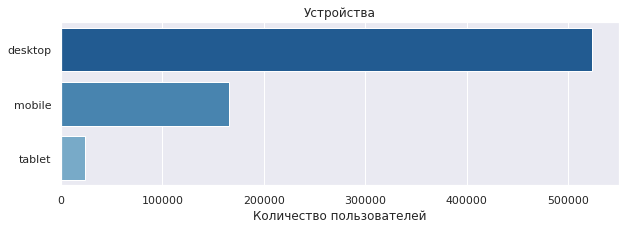

In [103]:
plt.figure(figsize=(10,3))

channel_values = train.groupby('id', sort = False).apply(lambda x: x['device_deviceCategory'].values[0]).values
cnt = Counter(channel_values)
palette = sns.color_palette('Blues', n_colors = len(cnt) + 2)

sns.countplot(y = channel_values, order = [el[0] for el in cnt.most_common()],
             palette = palette[::-1])
plt.xlabel('Количество пользователей')
plt.title('Устройства')
#plt.xticks(np.arange(0, 320000, 25000), rotation = 30)
plt.show()

Ну и есть информация про операционную систему пользователя:

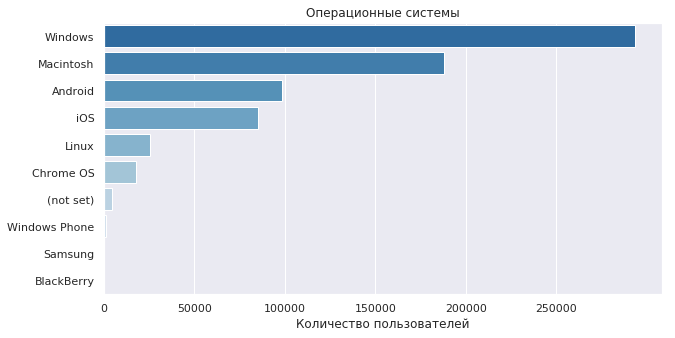

In [104]:
plt.figure(figsize=(10,5))

cnt = Counter(train.groupby('id', sort = False).apply(lambda x: Counter(x['device_operatingSystem']).most_common()[0][0]))
browser_values = sum([[el[0]] * el[1] for el in cnt.most_common()[:10]], [])
cnt = Counter(browser_values)
palette = sns.color_palette('Blues', n_colors = len(cnt) + 2)

sns.countplot(y = browser_values, order = [el[0] for el in cnt.most_common()],
             palette = palette[::-1][2:])
plt.xlabel('Количество пользователей')
plt.title('Операционные системы')
plt.xticks(np.arange(0, 300000, 50000), rotation = 0)
plt.show()

In [105]:
train.columns

Index(['channel', 'date', 'id', 'visitId', 'visitNumber', 'visitStartTime',
       'device_browser', 'device_deviceCategory', 'device_isMobile',
       'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent',
       'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain',
       'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces',
       'totals_hits', 'totals_newVisits', 'totals_pageviews', 'target',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'label'],
      dtype='object')

Немного отдохнем от категориальных признаков:

* totals_pageviews - количество страниц на сайте, просмотренных пользователем в данную сессию
* totals_hits - количество всяких разных обращений к серверу (загрузка картинки на странице, добавление в корзину товара)
* totals_bounces - понятие "bounce", по всей видимости, означает крайне короткую пользовательскую сессию, при которой у нас в трейне ВСЕГДА не происходит покупка.
* totals_newVisits - если это первая сессия пользователя - единичка, иначе - ноль

In [110]:
# Создание сбалансированной выборки
pos_ids = set(train[train['label'] == 1]['id'].unique())
neg_ids = set(np.random.permutation(train[train['label'] == 0]['id'].unique())[:len(pos_ids)])

sample_ids = pos_ids.union(neg_ids)
sample = train[train['id'].apply(lambda x: x in sample_ids)].copy()
sample.reset_index(inplace = True)

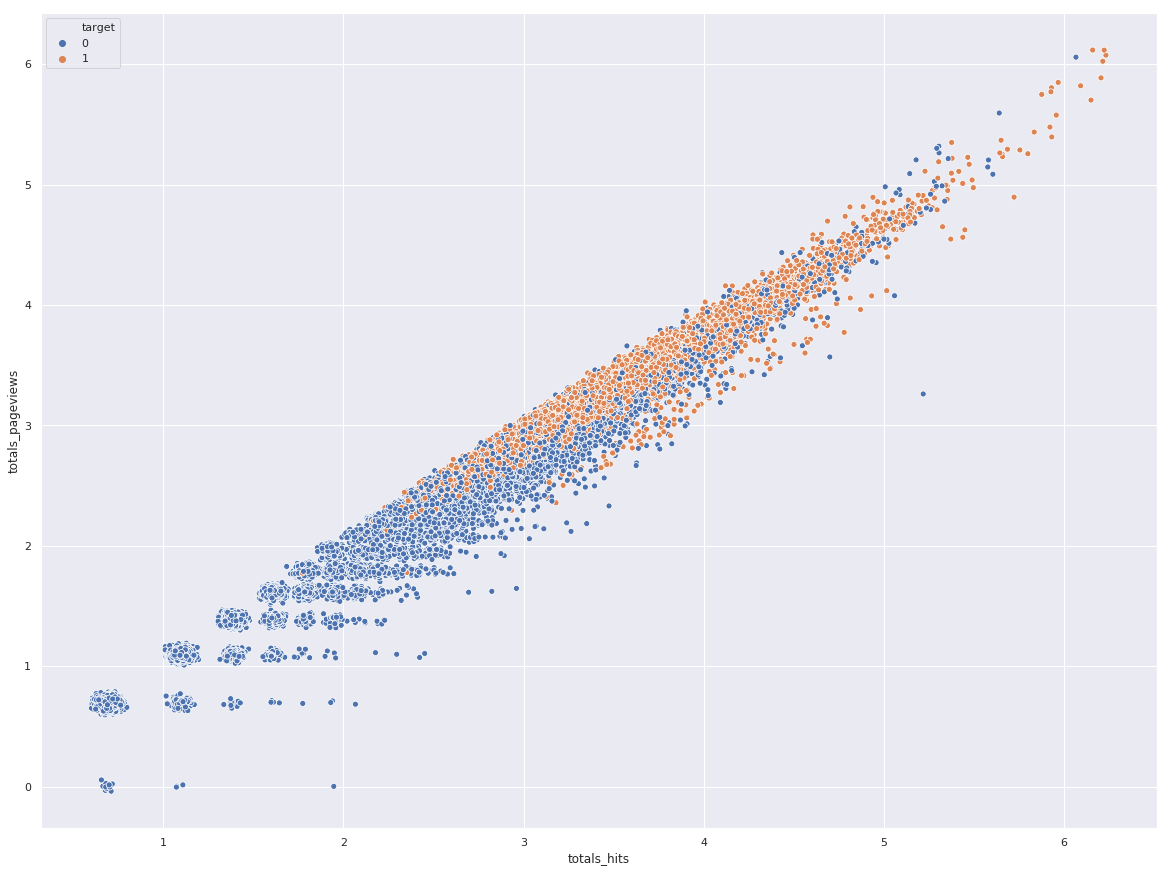

In [117]:
plt.figure(figsize = (20, 15))
sns.scatterplot(np.log1p(sample['totals_hits']) + np.random.normal(0, 0.025, sample.shape[0]), np.log1p(sample['totals_pageviews']) + np.random.normal(0, 0.025, sample.shape[0]), hue = (sample['target'] > 0).astype(int))

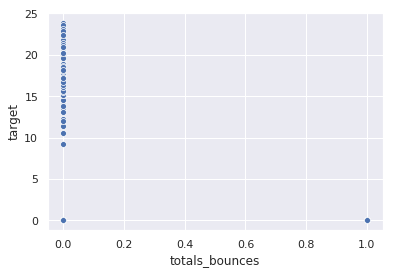

In [118]:
sns.scatterplot(train['totals_bounces'], np.log1p(train['target']))

In [ ]:
n, bins, patches = plt.hist(x = np.log1p(train['totals_hits']), bins = 20, orientation = 'vertical', 
                            align = 'left', 
                            color = '#6b8ba4', edgecolor = 'white',
        )
        
#plt.yticks(bins, list(cat_dct.keys()))
plt.xlim(0.3, 5)
plt.title('Количество посещений, различие по тратам')
plt.legend(['less than average', 'more than average'])
plt.xlabel('Количество пользователей')
plt.show()

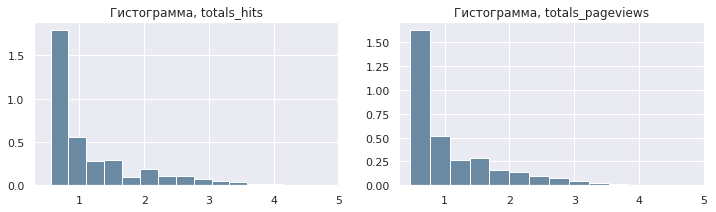

In [127]:
plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(x = np.log1p(train['totals_hits']), bins = 20, orientation = 'vertical', 
                            align = 'left', 
                            color = '#6b8ba4', edgecolor = 'white', density = True,
        )
        
#plt.yticks(bins, list(cat_dct.keys()))
plt.xlim(0.3, 5)
plt.title('Гистограмма, totals_hits')

plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(x = np.log1p(train['totals_pageviews']), bins = 20, orientation = 'vertical', 
                            align = 'left', 
                            color = '#6b8ba4', edgecolor = 'white', density = True,
        )
        
#plt.yticks(bins, list(cat_dct.keys()))
plt.xlim(0.3, 5)
plt.title('Гистограмма, totals_pageviews')
plt.show()


Про missing values:

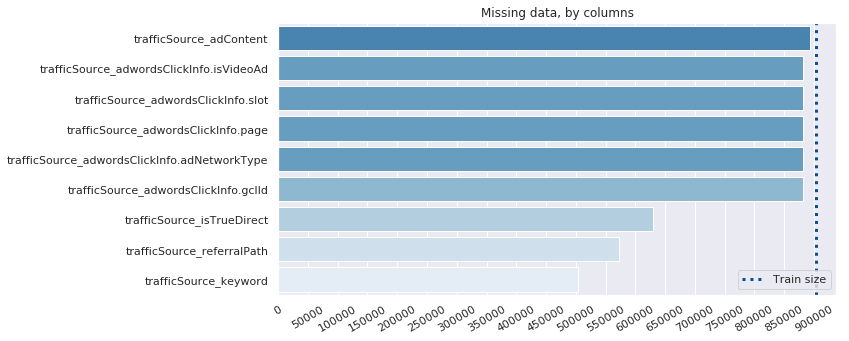

In [129]:
counts = train.shape[0] - train.count().sort_values()
counts = counts[counts != 0]

vals = sorted(list(set(counts.values)), reverse = True)
palette = sns.color_palette('Blues_r', n_colors = len(counts.unique()) + 2)
val2idx = {vals[i]:i for i in range(len(vals))}

plt.figure(figsize = (10, 5))
sns.barplot(x = counts.values, y = counts.index, orient = 'horizontal', 
            palette = [palette[val2idx[val] + 2] for val in counts.values])
plt.xticks(np.arange(0, train.shape[0], 50000), rotation = 30)
plt.yticks(rotation = 0)
plt.title('Missing data, by columns')
plt.legend([plt.axvline(x=train.shape[0], lw = 3., c = palette[0], ls = ':')], ['Train size'], loc = 'lower right')
plt.show()

2 - 5 колонки неслучайно закрашены одним цветом! Да-да, у них одинаковое количество пропусков.

Настало время геоданных:

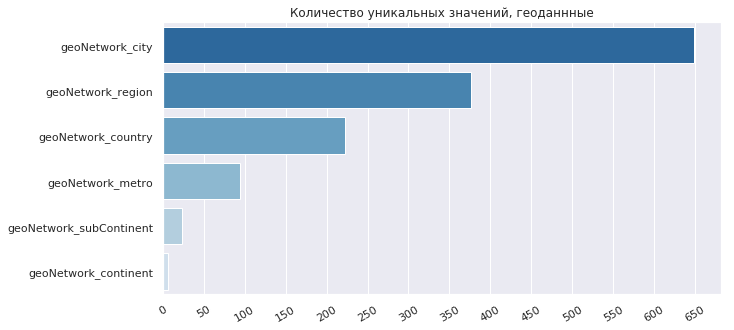

In [130]:
counts = train.fillna('nan').nunique()
geodata = ['geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
          'geoNetwork_region', 'geoNetwork_subContinent']

geo_counts = counts[geodata].sort_values(ascending = False)

vals = sorted(list(set(geo_counts.values)), reverse = True)
palette = sns.color_palette('Blues_r', n_colors = len(geo_counts.unique()) + 2)
val2idx = {vals[i]:i for i in range(len(vals))}

plt.figure(figsize = (10, 5))
sns.barplot(x = geo_counts.values, y = geo_counts.index, orient = 'horizontal', 
            palette = [palette[val2idx[val] + 1] for val in geo_counts.values])

plt.xticks(np.arange(0, 700, 50), rotation = 30)
plt.yticks(rotation = 0)
plt.title('Количество уникальных значений, геоданнные')
plt.show()

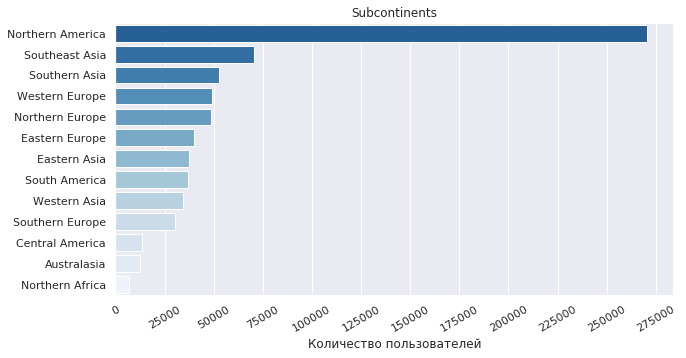

In [132]:
plt.figure(figsize=(10,5))

channel_values = train.groupby('id', sort = False).apply(lambda x: Counter(x['geoNetwork_subContinent'].values).most_common()[0][0]).values
cnt = Counter(channel_values)
channel_values = sum([[el[0]] * el[1] for el in cnt.most_common()[:13]], [])
cnt = Counter(channel_values)
palette = sns.color_palette('Blues', n_colors = len(cnt) + 2)

sns.countplot(y = channel_values, order = [el[0] for el in cnt.most_common()],
             palette = palette[::-1][2:])
plt.xlabel('Количество пользователей')
plt.title('Subcontinents')
plt.xticks(np.arange(0, 300000, 25000), rotation = 30)
plt.show()

In [134]:
devices_nunique = train.groupby('id', sort = False)['geoNetwork_subContinent'].nunique().values
print(Counter(devices_nunique))

Counter({1: 712587, 2: 1537, 3: 39, 4: 4})


Некоторые люди заходят в разные сессии с разных сабконтинентов, что бы это не значило.

In [135]:
labels = (train.groupby('id', sort = False)['target'].sum() > 0).astype(int).values
Counter(devices_nunique[labels == 1])

Counter({1: 9871, 2: 120, 3: 5})

Такие есть и среди тех, кто покупает - на самом деле, даже не малая доля.

Вернемся к количеству визитов за сутки:

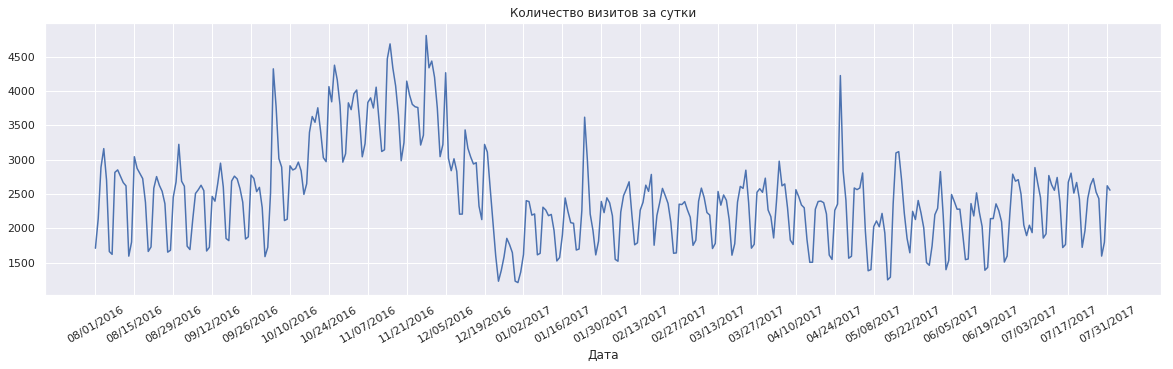

In [138]:
visits_by_day = Counter(train['date'])

plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(calendar, [visits_by_day[date] for date in calendar])
plt.xticks(calendar[::14], rotation = 30)
plt.title('Количество визитов за сутки')
plt.xlabel('Дата')
plt.show()

У нас теперь есть страны, континенты, и прочее, а значит можно смотреть подобную инфу только по ним:

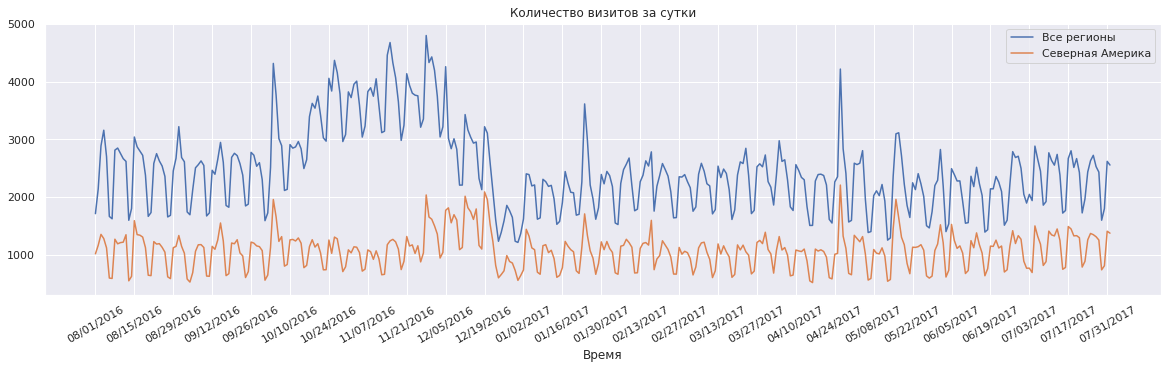

In [140]:
cnt = Counter(train[train['geoNetwork_subContinent'] == 'Northern America']['date'])
plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(calendar, [visits_by_day[date] for date in calendar])
plt.plot(calendar, [cnt[date] for date in calendar])
plt.xticks(calendar[::14], rotation = 30)
plt.title('Количество визитов за сутки')
plt.xlabel('Время')
plt.legend(['Все регионы', 'Северная Америка'])
plt.show()

In [142]:
values = train.groupby('id', sort = False).apply(lambda x: Counter(x['geoNetwork_subContinent'].values).most_common()[0][0]).values
region_cnt = Counter(values)

In [144]:
regions = [el[0] for el in region_cnt.most_common()[:13]]

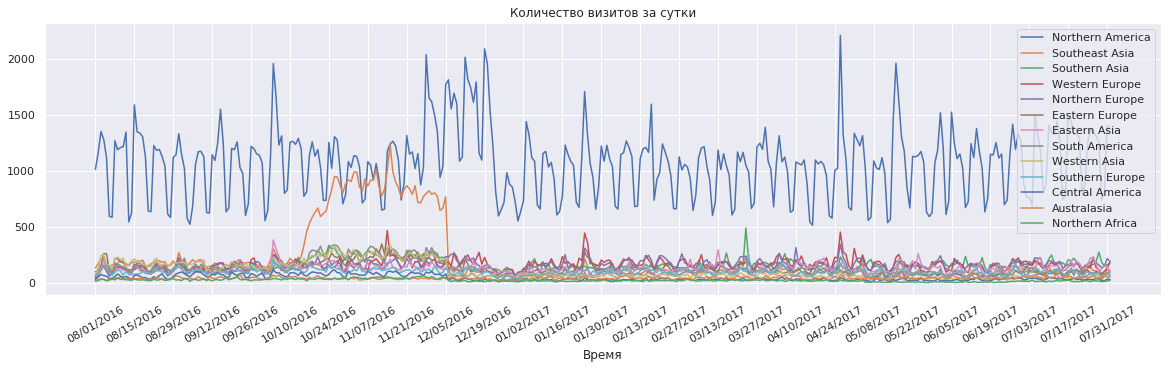

In [145]:
cnts = []
for region in regions:
    cnts.append(Counter(train[train['geoNetwork_subContinent'] == region]['date']))
plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
for cnt in cnts:
    plt.plot(calendar, [cnt[date] for date in calendar])
plt.xticks(calendar[::14], rotation = 30)
plt.title('Количество визитов за сутки')
plt.xlabel('Время')
plt.legend(regions)
#plt.gcf().autofmt_xdate()
plt.show()

Ну что сказать: Северная Америка и Юговосточная Азия очень выделяются:

* Северная Америка понятно почему: активно закупаются перед рождеством.

* Азия - может там японский Новый Год? Надо исследовать.

Да и опять: надо сравнить с тестом, дабы проверить сезонность.

Про другие регионы ничего непонятно, посмотрим на них отдельно:

In [146]:
regions = [el[0] for el in region_cnt.most_common()[2:13]]

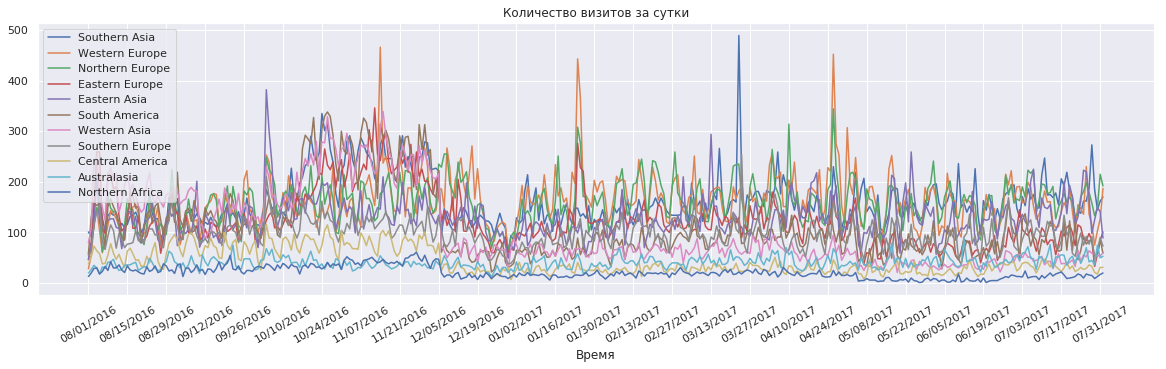

In [147]:
cnts = []
for region in regions:
    cnts.append(Counter(train[train['geoNetwork_subContinent'] == region]['date']))
plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
for cnt in cnts:
    plt.plot(calendar, [cnt[date] for date in calendar])
plt.xticks(calendar[::14], rotation = 30)
plt.title('Количество визитов за сутки')
plt.xlabel('Время')
plt.legend(regions)
#plt.gcf().autofmt_xdate()
plt.show()

Виднеется небольшой "горбик" осенью, ну и несколько пиков. Что примечательно, пики соответствуют только определенным регионам - это либо праздники, либо какие-то region-specific акции. Опять же, для определения праздников можно сравнить с тестом.

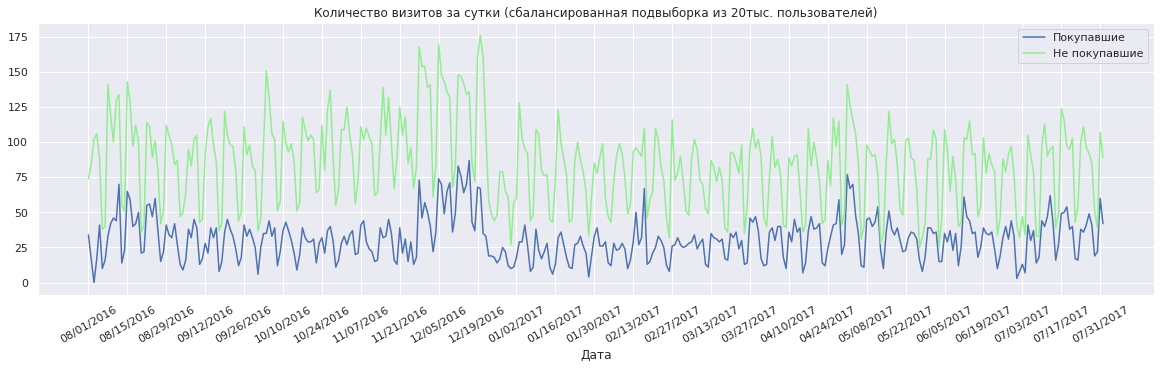

In [174]:
x = sample[sample['target'] == 0].groupby(['id', 'date'], sort = False).size()
neg_dates = [el[1] for el in x.index]
neg_cnt = Counter(neg_dates)

x = sample[sample['target'] > 0].groupby(['id', 'date'], sort = False).size()
pos_dates = [el[1] for el in x.index]
pos_cnt = Counter(pos_dates)

plt.figure(figsize = (20, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(calendar, [pos_cnt[date] for date in calendar])
plt.plot(calendar, [neg_cnt[date] for date in calendar], color = 'lightgreen')
plt.xticks(calendar[::14], rotation = 30)
plt.legend(['Покупавшие', 'Не покупавшие'])
plt.title('Количество визитов за сутки (сбалансированная подвыборка из 20тыс. пользователей)')
plt.xlabel('Дата')
plt.show()

Не покупавшие пользователи чаще заходят на сайт - это в каком-то смысле логично. Они более избирательны и им необходимо больше времени перед покупкой (раз уж они ничего еще не покупили). Это подтверждается следующими гистограммами:

In [175]:
pos_sample = sample[sample['target'] > 0].copy()
neg_sample = sample[sample['target'] == 0].copy()

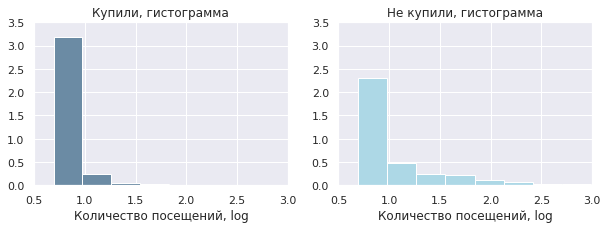

In [202]:
pos_visits = pos_sample.groupby('id', sort = False).size()
neg_visits = neg_sample.groupby('id', sort = False).size()

plt.figure(figsize = (10, 3))
plt.subplot(1, 2, 1)
plt.title('Купили, гистограмма')
plt.xlabel('Количество посещений, log')
n, bins, patches = plt.hist(x = np.log1p(pos_visits), bins = 10, orientation = 'vertical', #align = 'left', 
                            color = '#6b8ba4', edgecolor = 'white', density = True)
        
plt.xlim(0.5, 3)
plt.ylim(0, 3.5)
plt.subplot(1, 2, 2)
plt.title('Не купили, гистограмма')
n, bins, patches = plt.hist(x = np.log1p(neg_visits), bins = 17, orientation = 'vertical', #align = 'left', 
                            color = 'lightblue', edgecolor = 'white', density = True)
plt.xlabel('Количество посещений, log')
#plt.xticks([])
#plt.yticks([])
plt.ylim(0, 3.5)
plt.xlim(0.5, 3)

plt.show()

Да, по гистограммам видно, что те, кто ничего не покупали, больше склоняются к большому количеству просмотра сайта.

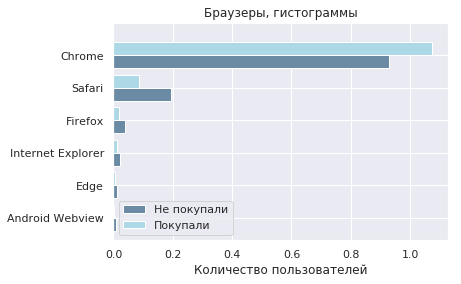

In [227]:
pos_samples = pos_sample.groupby('id', sort = False).apply(lambda x: Counter(x['device_browser']).most_common()[0][0])
neg_samples = neg_sample.groupby('id', sort = False).apply(lambda x: Counter(x['device_browser']).most_common()[0][0])
cats = [el[0] for el in Counter(list(pos_samples) + list(neg_samples)).most_common()]
cat2idx = dict((cats[::-1][i], i) for i in np.arange(len(cats)))

pos_cnt = Counter(pos_samples)
neg_cnt = Counter(neg_samples)

pos_samples = sum([[el] * pos_cnt[el] for el in cats[:6]], [])
neg_samples = sum([[el] * neg_cnt[el] for el in cats[:6]], [])

values = [[cat2idx[el] for el in data] for data in [neg_samples, pos_samples]]
n, bins, patches = plt.hist(x = values, bins = 6, orientation = 'horizontal', align = 'left', 
                            color = ['#6b8ba4', 'lightblue'], edgecolor = 'white', density = True)
plt.yticks(bins, cats[::-1][-6:])
plt.title('Браузеры, гистограммы')
plt.legend(['Не покупали', 'Покупали'])
plt.xlabel('Количество пользователей')
plt.show()

Среди пользователей хрома больше людей покупали, у остальных браузеров - наоборот. Вывод: успешные люди пользуются хромом!

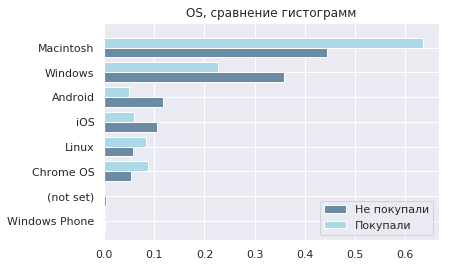

In [229]:
col = 'device_operatingSystem'
l = 8

pos_samples = pos_sample.groupby('id', sort = False).apply(lambda x: Counter(x[col]).most_common()[0][0])
neg_samples = neg_sample.groupby('id', sort = False).apply(lambda x: Counter(x[col]).most_common()[0][0])
cats = [el[0] for el in Counter(list(pos_samples) + list(neg_samples)).most_common()]
cat2idx = dict((cats[::-1][i], i) for i in np.arange(len(cats)))

pos_cnt = Counter(pos_samples)
neg_cnt = Counter(neg_samples)

pos_samples = sum([[el] * pos_cnt[el] for el in cats[:l]], [])
neg_samples = sum([[el] * neg_cnt[el] for el in cats[:l]], [])

values = [[cat2idx[el] for el in data] for data in [neg_samples, pos_samples]]
n, bins, patches = plt.hist(x = values, bins = l, orientation = 'horizontal', align = 'left', 
                            color = ['#6b8ba4', 'lightblue'], edgecolor = 'white', density = True)
plt.yticks(bins, cats[::-1][-l:])
plt.title('OS, сравнение гистограмм')
plt.legend(['Не покупали', 'Покупали'], loc = 'lower right')
#plt.xlabel('Количество пользователей')
plt.show()

* Macintosh: много покупают
* Windows: не тратятся!
* Android: тратятся МЕНЬШЕ ВСЕХ
* Linux: удивительно, но как раз пользователи Линукса покупают

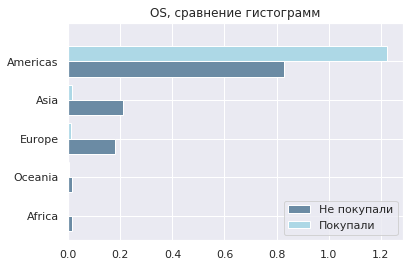

In [231]:
col = 'geoNetwork_continent'
l = 5

pos_samples = pos_sample.groupby('id', sort = False).apply(lambda x: Counter(x[col]).most_common()[0][0])
neg_samples = neg_sample.groupby('id', sort = False).apply(lambda x: Counter(x[col]).most_common()[0][0])
cats = [el[0] for el in Counter(list(pos_samples) + list(neg_samples)).most_common()]
cat2idx = dict((cats[::-1][i], i) for i in np.arange(len(cats)))

pos_cnt = Counter(pos_samples)
neg_cnt = Counter(neg_samples)

pos_samples = sum([[el] * pos_cnt[el] for el in cats[:l]], [])
neg_samples = sum([[el] * neg_cnt[el] for el in cats[:l]], [])

values = [[cat2idx[el] for el in data] for data in [neg_samples, pos_samples]]
n, bins, patches = plt.hist(x = values, bins = l, orientation = 'horizontal', align = 'left', 
                            color = ['#6b8ba4', 'lightblue'], edgecolor = 'white', density = True)
plt.yticks(bins, cats[::-1][-l:])
plt.title('OS, сравнение гистограмм')
plt.legend(['Не покупали', 'Покупали'], loc = 'lower right')
#plt.xlabel('Количество пользователей')
plt.show()